# Case-by-case analysis
This notebook demonstrates how to visualize which model managed to solve which test-case how often.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
directory = "../data/"

collection = []
for filename in os.listdir(directory):
    if filename.endswith("_results.jsonl"):
        print(filename)
        df = pd.read_json(directory + filename, lines=True)
        df['model'] = filename.replace(".jsonl_results.jsonl", "").replace("samples_", "")
        collection.append(df)

df = pd.concat(collection)

samples_canonical.jsonl_results.jsonl
samples_claude-3-opus-20240229.jsonl_results.jsonl
samples_codellama.jsonl_results.jsonl
samples_gemini-pro.jsonl_results.jsonl
samples_gpt-3.5-turbo-1106.jsonl_results.jsonl
samples_gpt-4-1106-preview.jsonl_results.jsonl
samples_gpt-4-turbo-2024-04-09.jsonl_results.jsonl
samples_Mistral-7B-Instruct-v0.2.jsonl_results.jsonl


In [3]:
df

,task_id,completion,full_response,result,passed,model
0,../test_cases/apply_otsu_threshold_and_count_p...,\n import skimage\n import numpy as np\n...,\n import skimage\n import numpy as np\n...,passed,True,canonical
1,../test_cases/binary_closing.ipynb,\n import numpy as np\n import skimage\n...,\n import numpy as np\n import skimage\n...,passed,True,canonical
2,../test_cases/convex_hull_measure_area.ipynb,\n import vedo\n convex_hull = vedo.shap...,\n import vedo\n convex_hull = vedo.shap...,passed,True,canonical
3,../test_cases/convolve_images.ipynb,\n import scipy\n return scipy.ndimage.c...,\n import scipy\n return scipy.ndimage.c...,passed,True,canonical
4,../test_cases/count_number_of_touching_neighbo...,\n import numpy as np\n import pyclesper...,\n import numpy as np\n import pyclesper...,timed out,False,canonical
...,...,...,...,...,...,...
465,../test_cases/worflow_segmentation_measurement...,\nimport numpy as np\nfrom scipy.ndimage impor...,```python\nimport numpy as np\nfrom scipy.ndim...,failed: cannot import name 'measure' from 'sci...,False,Mistral-7B-Instruct-v0.2
466,../test_cases/worflow_watershed_segmentation_c...,\nimport numpy as np\nfrom scipy.ndimage impor...,Here's the completed code based on your descri...,failed: cannot import name 'watershed' from 's...,False,Mistral-7B-Instruct-v0.2
467,../test_cases/workflow_batch_process_folder_co...,\nimport os\nimport skimage.io as io\n\ndef wo...,```python\nimport os\nimport skimage.io as io\...,failed: [WinError 3] The system cannot find th...,False,Mistral-7B-Instruct-v0.2
468,../test_cases/workflow_batch_process_folder_me...,\nimport os\nimport numpy as np\nimport pandas...,```python\nimport os\nimport numpy as np\nimpo...,failed: [WinError 3] The system cannot find th...,False,Mistral-7B-Instruct-v0.2


In [4]:
# Ensure the 'passed' column is boolean for correct processing.
df['passed'] = df['passed'].astype(bool)
# shorten task name
df['task_id'] = [str(t).replace("../test_cases/", "") for t in df['task_id']]

# Pivot the dataframe to count True 'passed' values for each model-task combination.
pivot_df = df.pivot_table(index='task_id', columns='model', values='passed', aggfunc='mean', fill_value=0)

# Reset the index if 'task_id' needs to be a column instead of an index
pivot_df.reset_index(inplace=True)

# Apply formatting to display only two digits after the decimal point for all columns after the first (task_id column)
pivot_df = pivot_df.round(2)

# Show the transformation result (for verification)
def colorize(styler):
    styler.background_gradient(axis=None, cmap="PiYG")
    return styler

# Apply the formatting within the styling function using .format
pivot_df.style.pipe(colorize).format("{:.2f}", subset=pivot_df.columns[1:])

model,task_id,Mistral-7B-Instruct-v0.2,canonical,claude-3-opus-20240229,codellama,gemini-pro,gpt-3.5-turbo-1106,gpt-4-1106-preview,gpt-4-turbo-2024-04-09
0,apply_otsu_threshold_and_count_postiive_pixels.ipynb,0.00,1.00,0.00,0.00,0.20,0.00,0.00,0.00
1,binary_closing.ipynb,0.00,1.00,1.00,0.10,0.10,0.10,0.60,0.90
2,convex_hull_measure_area.ipynb,0.00,1.00,1.00,0.10,0.10,1.00,0.80,0.60
3,convolve_images.ipynb,0.00,1.00,0.60,0.00,0.00,0.20,0.30,0.30
4,count_number_of_touching_neighbors.ipynb,0.00,0.90,0.20,0.00,0.00,0.20,0.50,0.20
5,count_objects_over_time.ipynb,0.00,1.00,0.50,0.00,0.30,0.30,0.50,0.30
6,count_overlapping_regions.ipynb,0.00,1.00,1.00,0.00,0.00,0.20,1.00,1.00
7,create_umap.ipynb,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,crop_quarter_image.ipynb,0.30,1.00,0.90,0.10,0.40,0.20,0.20,0.60
9,deconvolve_image.ipynb,0.10,1.00,0.00,0.00,0.00,0.00,0.00,0.00


In [5]:
pivot_df.describe()

model,Mistral-7B-Instruct-v0.2,canonical,claude-3-opus-20240229,codellama,gemini-pro,gpt-3.5-turbo-1106,gpt-4-1106-preview,gpt-4-turbo-2024-04-09
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.119149,0.870213,0.395745,0.072340,0.117021,0.282979,0.421277,0.376596
std,0.245515,0.336810,0.398343,0.149931,0.223917,0.347863,0.383880,0.369614
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.400000,0.000000,0.000000,0.100000,0.400000,0.300000
75%,0.100000,1.000000,0.750000,0.100000,0.100000,0.450000,0.800000,0.650000
max,1.000000,1.000000,1.000000,0.700000,1.000000,1.000000,1.000000,1.000000


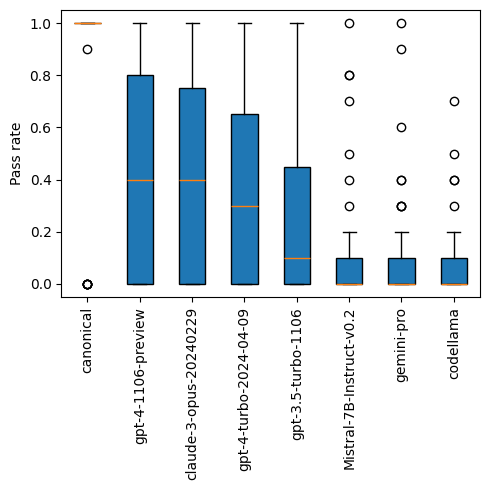

In [6]:
# Assuming pivot_df has 'task_id' as a non-numerical column and the rest are numerical and need to be plotted
numerical_data = pivot_df.drop(columns=['task_id'])

# Calculate the mean of each column and sort these means in descending order
mean_values = numerical_data.mean().sort_values(ascending=False)

# Reorder columns in numerical_data based on sorted mean values
ordered_numerical_data = numerical_data[mean_values.index]

# Plotting the boxplot with reordered columns
plt.figure(figsize=(5, 5))
boxplot = plt.boxplot(ordered_numerical_data, patch_artist=True, labels=ordered_numerical_data.columns)

# Adding colors
# colors = ['lightblue'] * len(ordered_numerical_data.columns)
#for patch, color in zip(boxplot['boxes'], colors):
#    patch.set_facecolor(color)

# plt.title('Pass rate for generated BIA Python code')
plt.xticks(rotation=90)  # Rotate labels to avoid overlap
plt.ylabel('Pass rate')  # Optionally adjust the label to suit the data context
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()